# Стартапы

## 0.Описание проекта

### 0.1.Задача проекта

Разработать модель для предсказания успешности стартапа (закроется или нет)

### 0.2.Описание данных

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

- kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Наша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
 - kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.
name - идентификатор (название) стартапа в тестовом наборе.
status - целевой признак. Для каждого стартапа необходимо предсказать категориальное значение соответствующее прогнозу ['operating', 'closed'].

### 0.3.Описание полей данных

- name - Название стартапа
- category_list - Список категорий, к которым относится стартап
- funding_total_usd - Общая сумма финансирования в USD
- status - Статус стартапа (закрыт или действующий)
- country_code - Код страны
- state_code - Код штата
- region - Регион
- city - Город
- funding_rounds - Количество раундов финансирования
- founded_at - Дата основания
- first_funding_at - Дата первого раунда финансирования
- last_funding_at - Дата последнего раунда финансирования
- closed_at - Дата закрытия стартапа (если применимо)
- lifetime - Время существования стартапа в днях

### 0.4.План выполения проекта

- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

## 1. Загрузка и подготовка данных

### 1.1. Чтение данных

In [27]:
# Установим необходимые библиотеки
!pip install phik
!pip install lightgbm

In [112]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns

from datetime import datetime

from lightgbm import LGBMClassifier

from matplotlib.dates import DateFormatter, MonthLocator

from scipy import stats as st

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import root_mean_squared_error, make_scorer, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, TargetEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import phik
import os

pd.set_option('display.float_format', '{:.2f}'.format)

In [29]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [30]:
sample_submit = pd.read_csv('kaggle_startups_sample_submit_28062024.csv')
test = pd.read_csv('kaggle_startups_test_28062024.csv', parse_dates=['first_funding_at', 'last_funding_at'])
train = pd.read_csv('kaggle_startups_train_28062024.csv', parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])

In [31]:
# Проверим размеры получившихся датасетов
print(sample_submit.shape)
print(test.shape)
print(train.shape)

(13125, 2)
(13125, 11)
(52516, 13)


### 1.2. Изучение общей информации о датасетах

In [32]:
# Создадим функцию для просмотра общей информации о датасетах
def overview_data(data):
    dash = '-' * 50

    print(dash)
    print('Основная информация о данных')
    print(dash)
    print(data.info())
    print('\n')

    print(dash)
    print('Первые строки данных')
    print(dash)
    print(data.head())
    print('\n')

    print(dash)
    print('Описательная статистика')
    print(dash)
    print(data.describe())
    print('\n')

    print(dash)
    print('Пропущенные значения')
    print(dash)
    print(data.isna().sum())
    print('\n')

    print(dash)
    print('Дубликаты')
    print(dash)
    print(data.duplicated().sum())
    print('\n')

In [33]:
# Выведем общую информацию о датасете train
overview_data(train)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datet

In [34]:
# Выведем общую информацию о датасете train
overview_data(test)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(

In [35]:
overview_data(sample_submit)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB
None


--------------------------------------------------
Первые строки данных
--------------------------------------------------
                     name     status
0              Crystalsol     closed
1        JBI Fish & Wings  operating
2                COINPLUS     closed
3  Imagine Communications     closed
4                   DNA13  operating


--------------------------------------------------
Описательная статистика
--------------------------------------------------
              name     status
count        13125      13125
unique       13125          2
top  

### Вывод

Датасет train
- в колонках funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at, status пропусков нет
- в колонке name один пропуск
- в остальных колонках от 2465 до 47599 пропусков
- пропуски в колоне closed_at скорее всего вызваны тем что стартап все еще существует или тем, что он существовал на момент акутализации данных
- пропуски в колонке funding_total_usd скорее всего вызваны тем что финансирования не было
- в колонках с датами не верный формат данных object
- в колонке funding_total_usd можно изменить формат на int т.к. думаю что центы в сумме финансирования не влияют на сумму
- явных дубликатов нет

Датасет test
- в колонках funding_rounds, first_funding_at, last_funding_at, status, name пропусков нет
- в остальных колонках от 591 до 2578 пропусков
- есть колонка lifetime - срок жизни стартапа, эту колонку нужно будет добавить в датасет train
- нет колонок founded_at и closed_at они заменены колонкой lifetime
- явных дубликатов нет

## 2. Анализ признаков

### 2.1. Анализ числовых признаков

In [36]:
# Функция построения диаграмм для числовых признаков
def num_diag(data, x, xlabel, ylabel, hue=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(
        data=data,
        x=x,
        hue=hue,
        ax=axes[0],
        stat="density",
        bins=20,
        common_norm=False
    )
    axes[0].set_title(f'Гистограмма по {xlabel}')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)

    sns.boxplot(
        data=data,
        x=x,
        ax=axes[1]
    )
    axes[1].set_title(f'Диаграмма размаха {xlabel}')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

In [37]:
# Функция построения диаграмм для категориальных признаков
def cat_diag(data, x, xlabel, hue=None, threshold=0.015):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    value_counts = data[x].value_counts(normalize=True)
    small_categories = value_counts[value_counts < threshold].index
    data_modified = data.copy()
    data_modified[x] = data_modified[x].apply(lambda val: 'Другие' if val in small_categories else val)

    sns.countplot(
        data=data_modified,
        x=x,
        hue=hue,
        ax=axes[0],
        order=data_modified[x].value_counts().index
    )
    axes[0].set_title(f'Диаграмма по {xlabel}')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(xlabel)
    axes[0].tick_params(axis='x', rotation=45)

    pie_data = data_modified[x].value_counts(normalize=True)

    pie_data.plot(
        kind='pie',
        labels=pie_data.index,
        legend=False,
        autopct='%1.0f%%',
        ax=axes[1],
        startangle=90,
        counterclock=False
    )
    axes[1].set_title(f'Распределение долей {xlabel}')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

In [38]:
# Создадим функцию для автоматической визуализации признаков в зависимости от типа колонки
def all_diag(df, column_type='numeric', hue=None):
    if column_type == 'numeric':
        columns = df.select_dtypes(include='number').columns
    elif column_type == 'categorical':
        columns = df.select_dtypes(include='object').columns

    for col in columns:
        if column_type == 'numeric':
            print(f"Визуализация численного признака: {col}")
            num_diag(df, x=col, xlabel=col, ylabel='Плотность распределения', hue=hue)
        elif column_type == 'categorical':
            print(f"Визуализация категориального признака: {col}")
            cat_diag(df, x=col, xlabel=col, hue=hue)

Визуализация численного признака: funding_total_usd


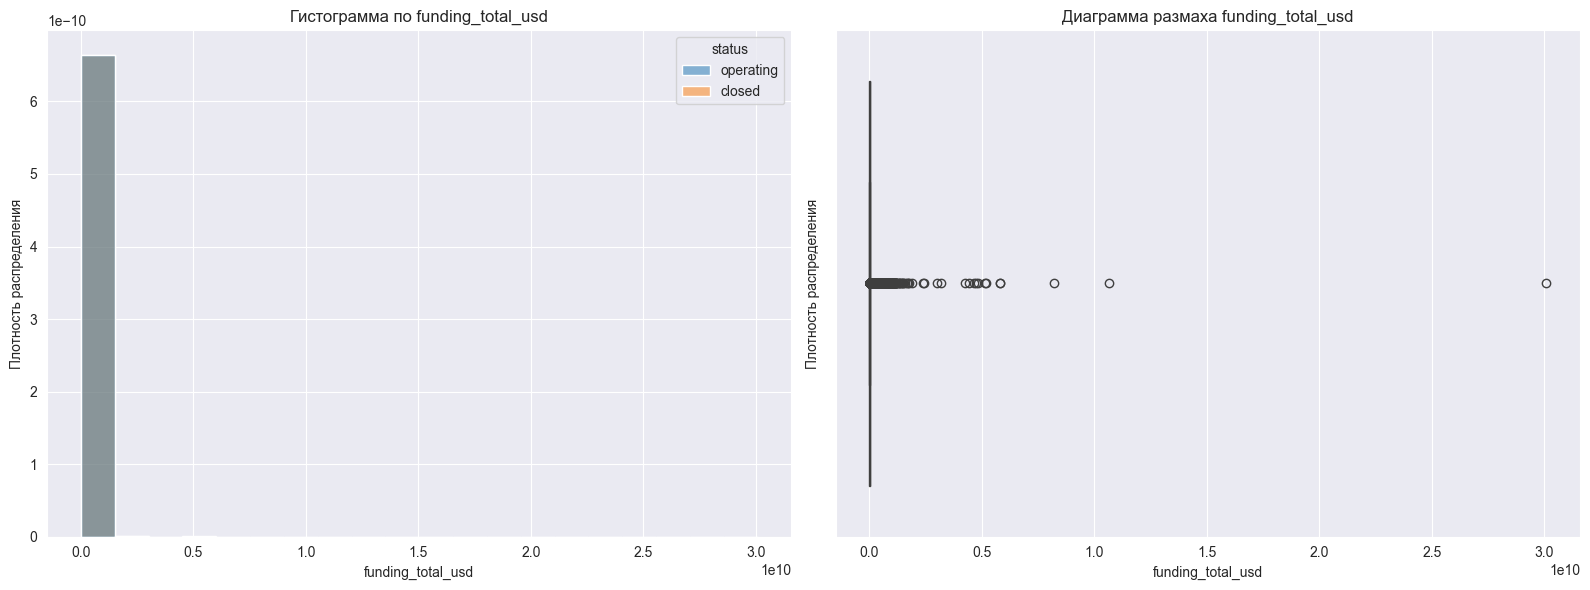

Визуализация численного признака: funding_rounds


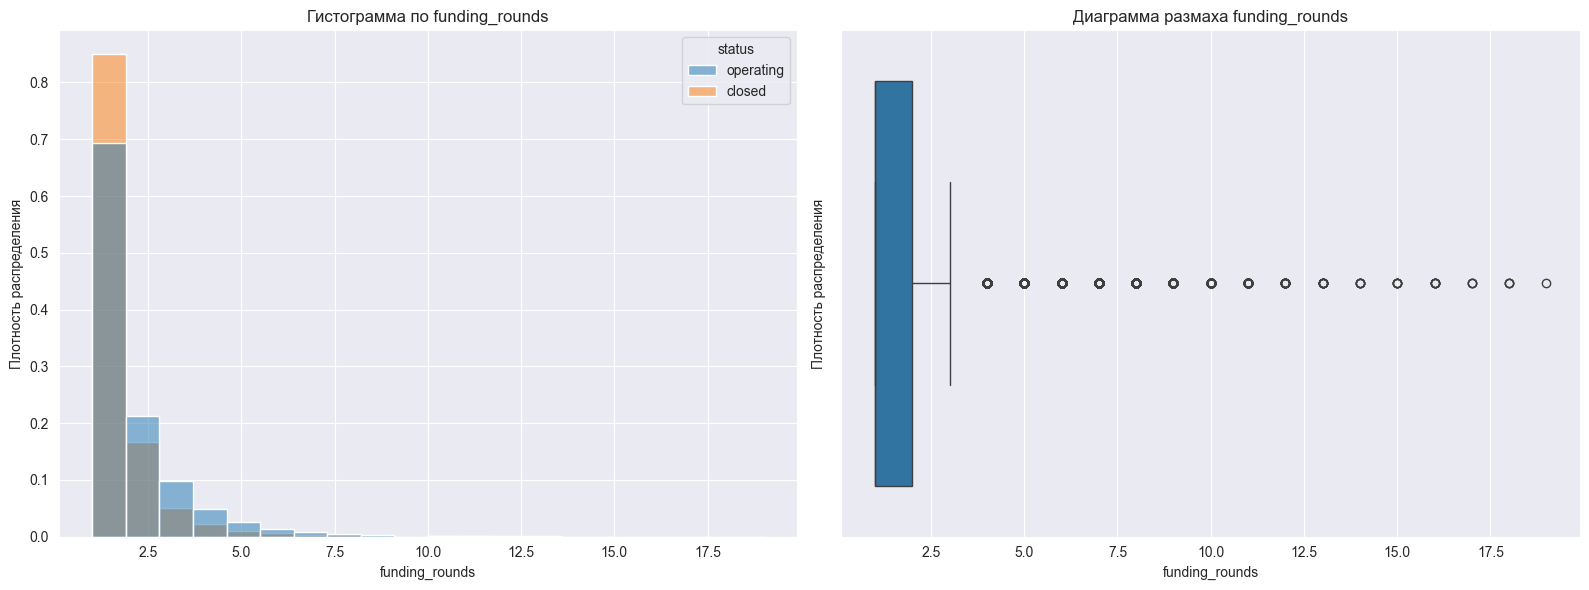

In [39]:
all_diag(train, column_type='numeric', hue='status')

In [40]:
train['funding_total_usd'].describe()

count         42447.00
mean       18247480.66
std       187117301.32
min               1.00
25%          336027.50
50%         2000000.00
75%        10000000.00
max     30079503000.00
Name: funding_total_usd, dtype: float64

funding_total_usd
- среднее значение финансирования составляет 18.2 млн.
- максимальное финансирование около 3 млрд. - думаю это реальное значение, было одно такое финасирование
- есть значение финансирования в 1 доллар
- большинство значений суммы финансирования находится в диапазоне между 336 тыс. и 10 млн

In [41]:
train['funding_rounds'].describe()

count   52516.00
mean        1.74
std         1.37
min         1.00
25%         1.00
50%         1.00
75%         2.00
max        19.00
Name: funding_rounds, dtype: float64

funding_total_usd
- среднее значение раундов финансирования составляет 1.74 раунда
- максимальное количество раундов 19
- минимальное количество раундов 1
- большинство значений раундов финансирования 1-2 раунда, все что больше единичные значения
- закрытых проектов после 5-6 раундов финансирования практически нет, однако и проектов с таким количеством финанирования тоже практически нет.

### 2.2. Анализ категориальных признаков

Подготовим данные к анализу

In [42]:
# Приведем все даты к нужному типу
date_cols1 = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
date_cols2 = ['first_funding_at', 'last_funding_at']
train[date_cols1] = train[date_cols1].apply(pd.to_datetime, errors='coerce')
test[date_cols2] = test[date_cols2].apply(pd.to_datetime, errors='coerce')

In [43]:
# Создадим столбцы с корневыми и конечными категориями
train['end_cat'] = train['category_list'].str.split('|').str[-1]
train['end_cat'] = train['end_cat'].fillna('other')
train['root_cat'] = train['category_list'].str.split('|').str[0]
train['root_cat'] = train['root_cat'].fillna('other')
test['end_cat'] = test['category_list'].str.split('|').str[-1]
test['end_cat'] = test['end_cat'].fillna('other')
test['root_cat'] = test['category_list'].str.split('|').str[0]
test['root_cat'] = test['root_cat'].fillna('other')


Визуализация категориального признака: name


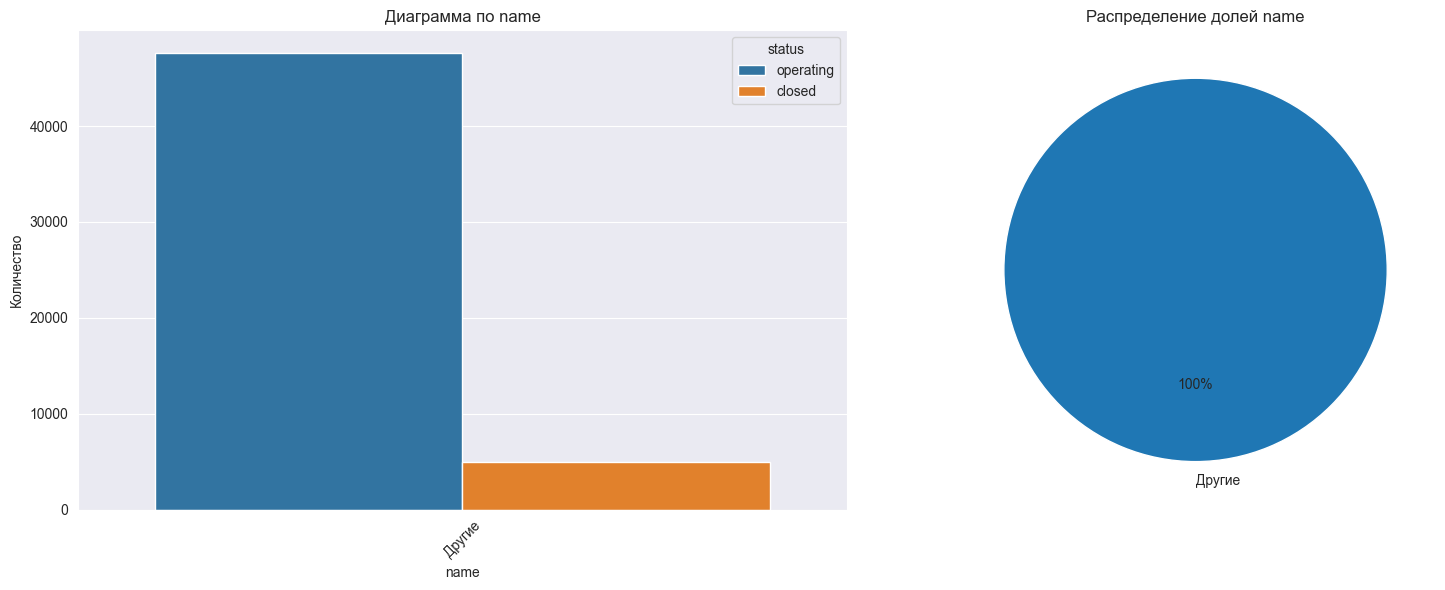

Визуализация категориального признака: category_list


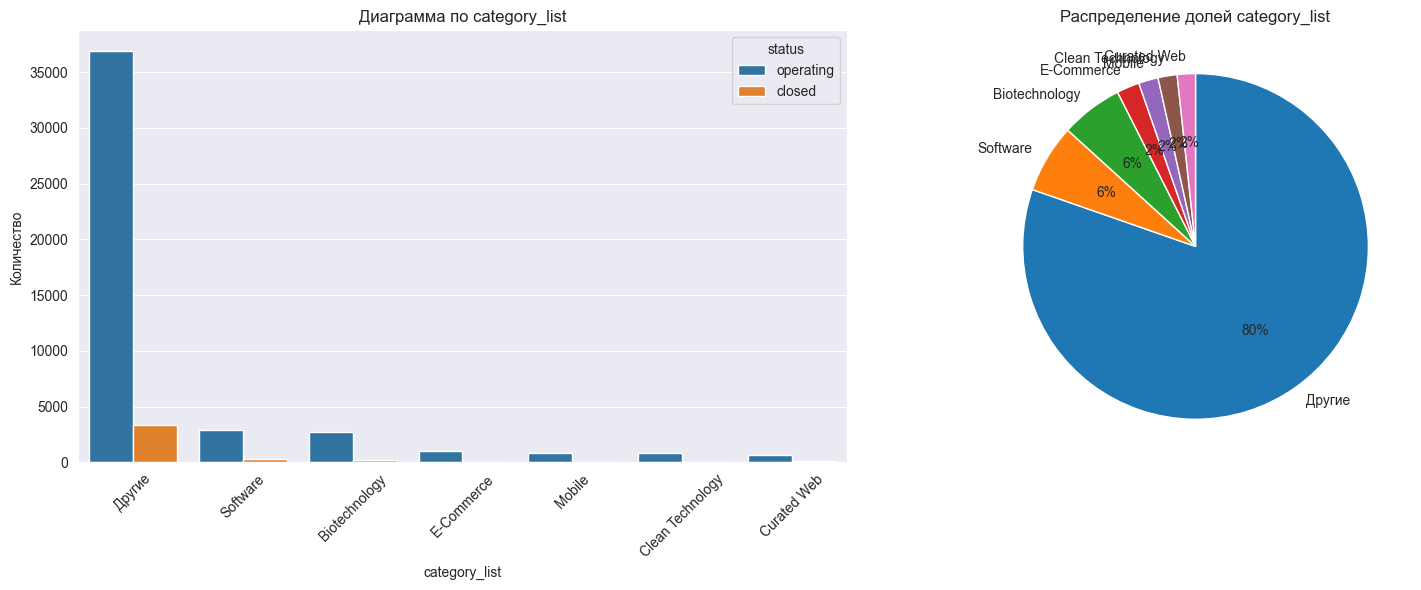

Визуализация категориального признака: status


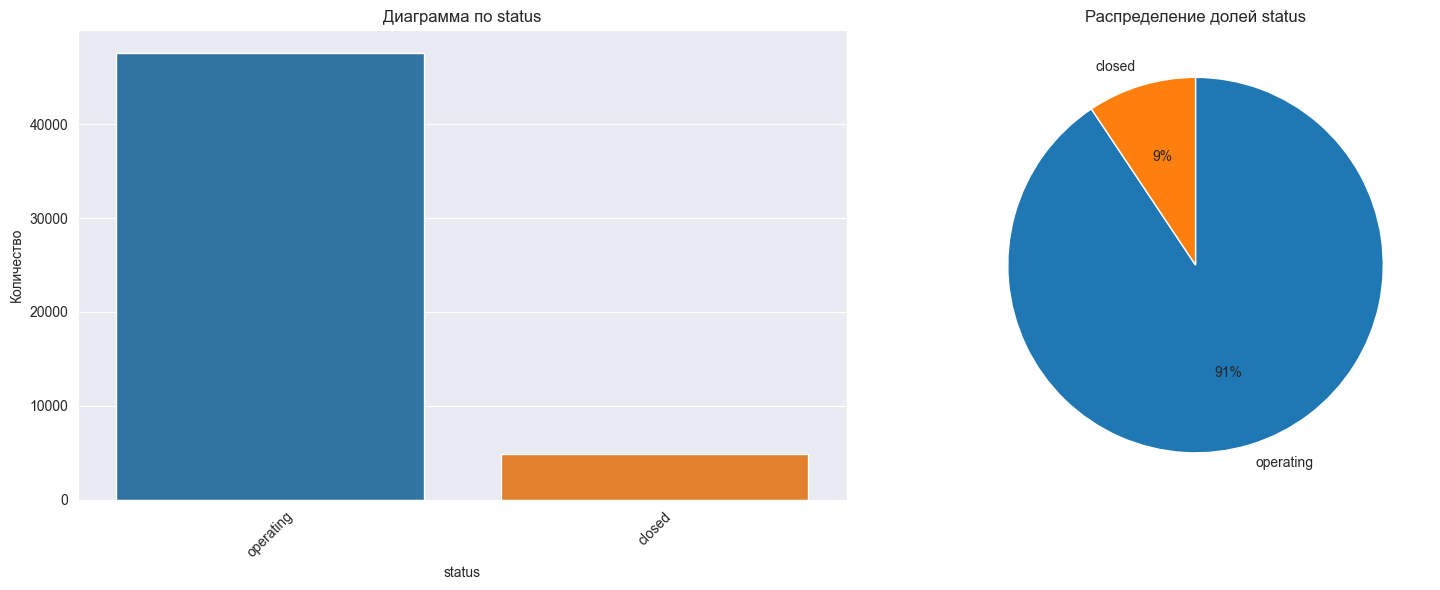

Визуализация категориального признака: country_code


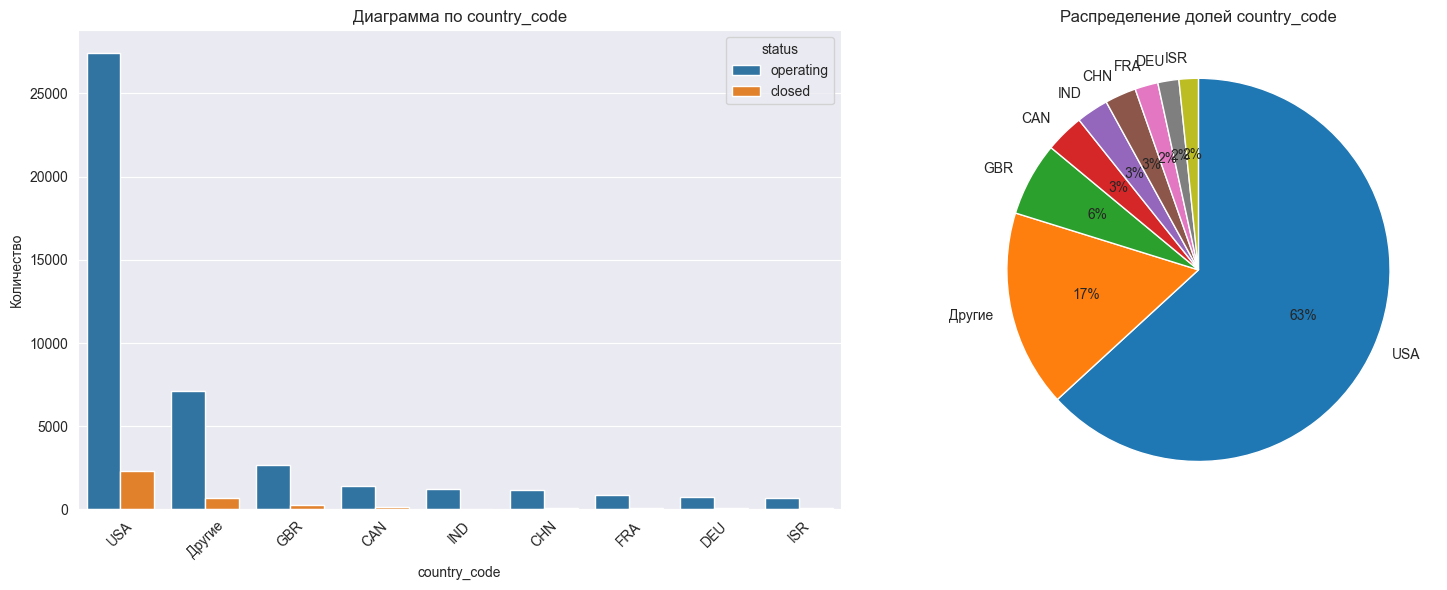

Визуализация категориального признака: state_code


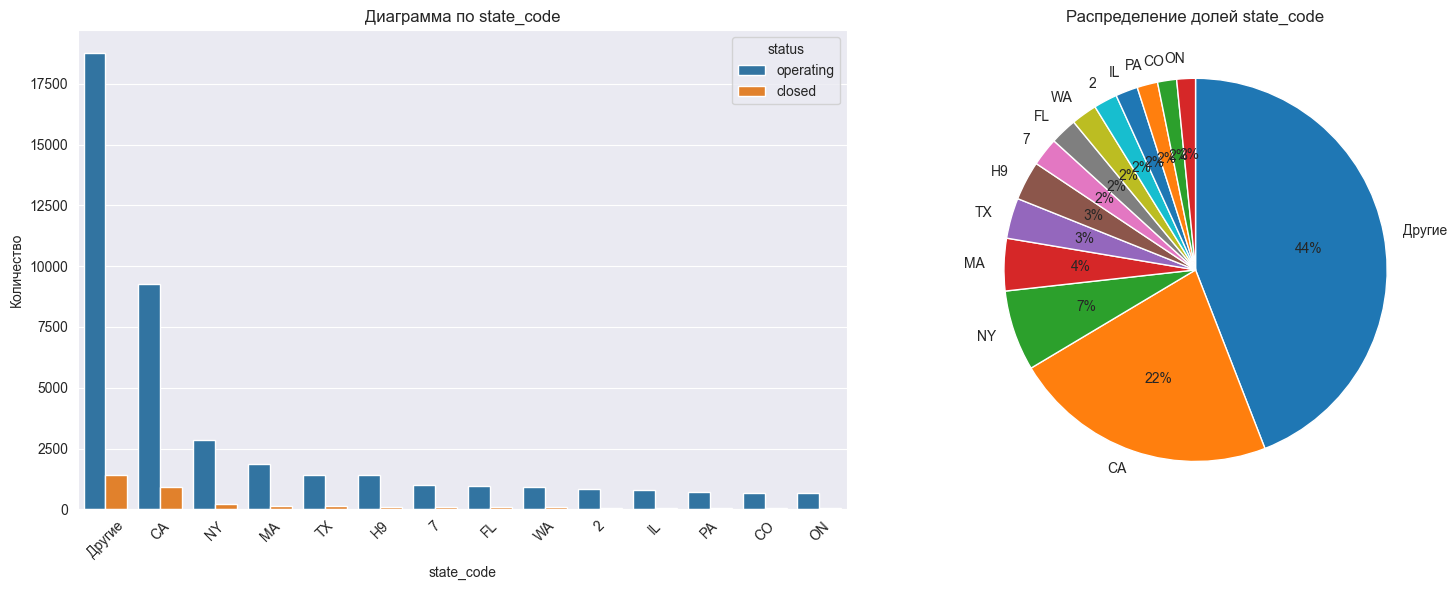

Визуализация категориального признака: region


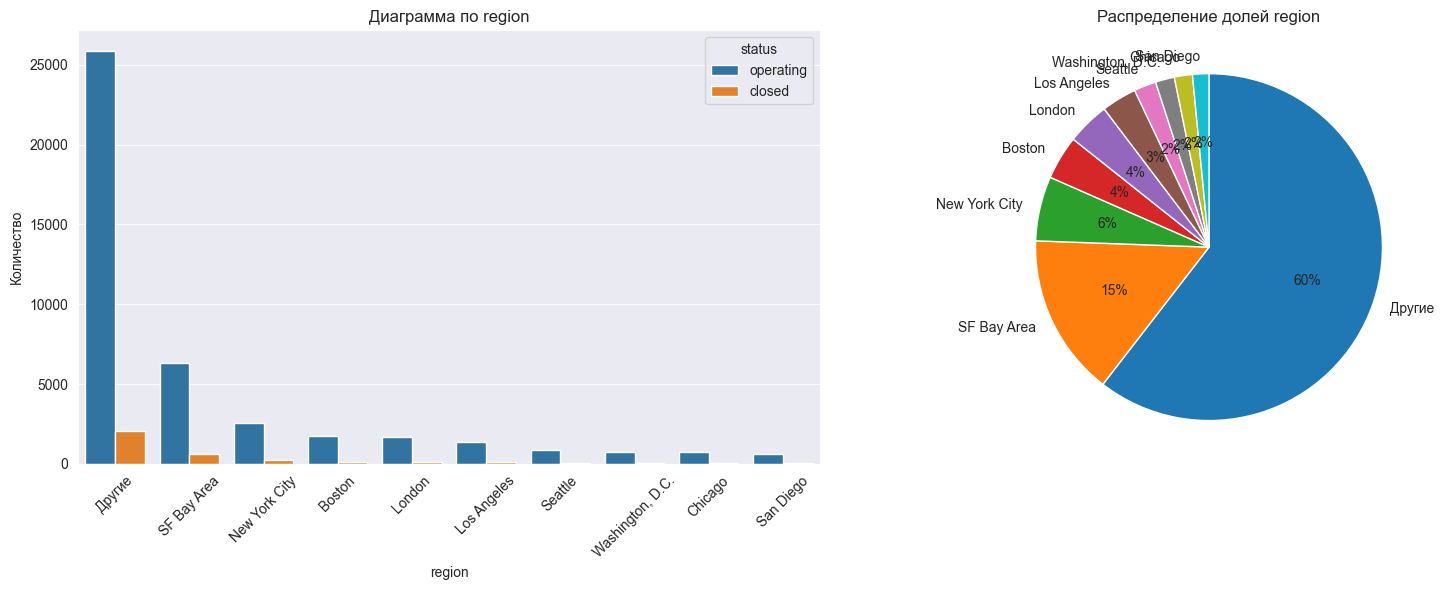

Визуализация категориального признака: city


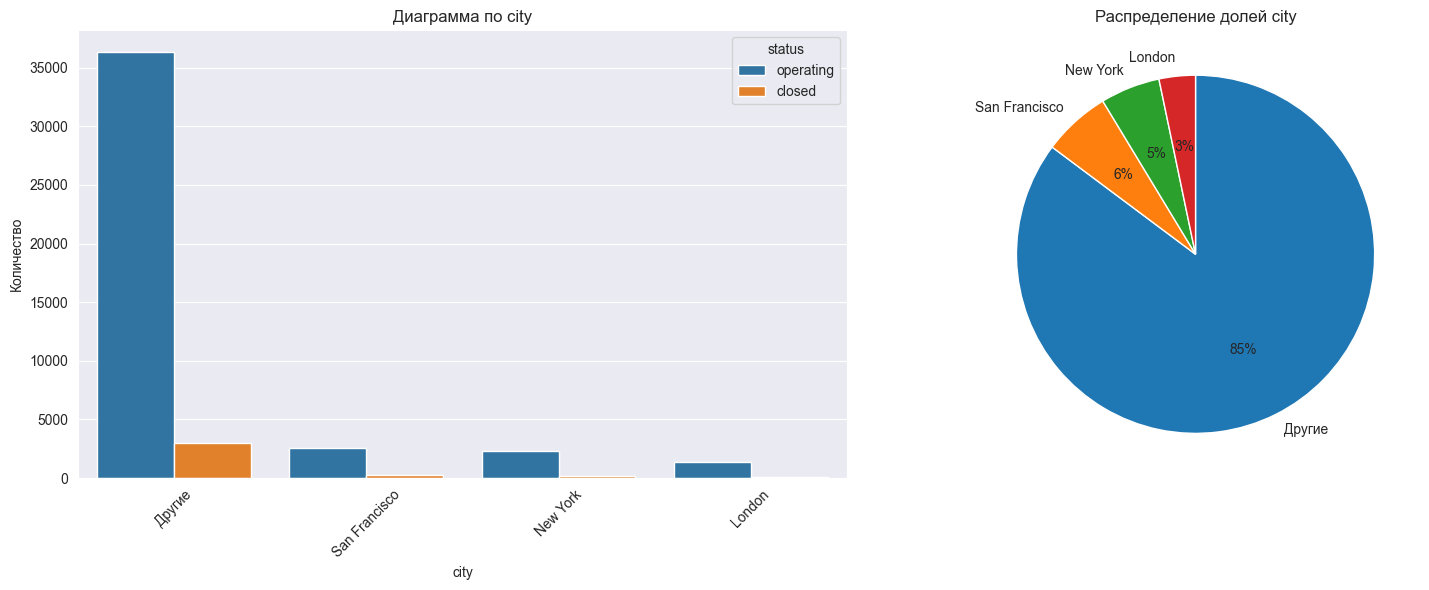

Визуализация категориального признака: end_cat


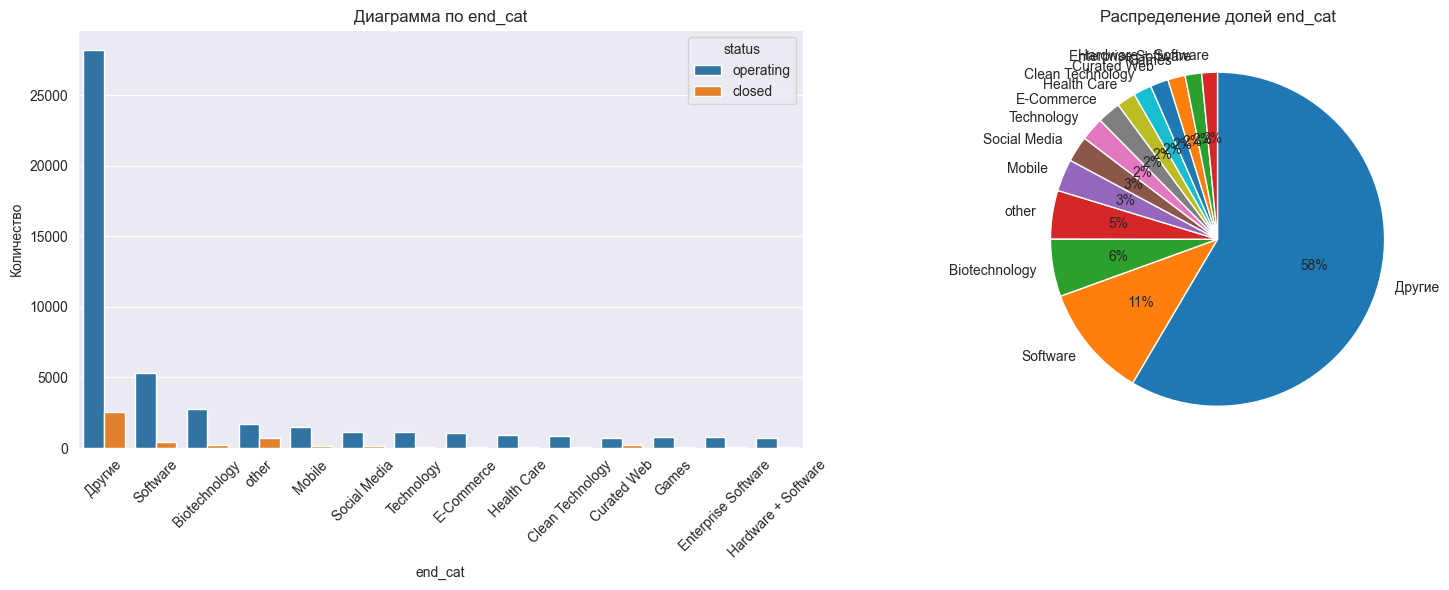

Визуализация категориального признака: root_cat


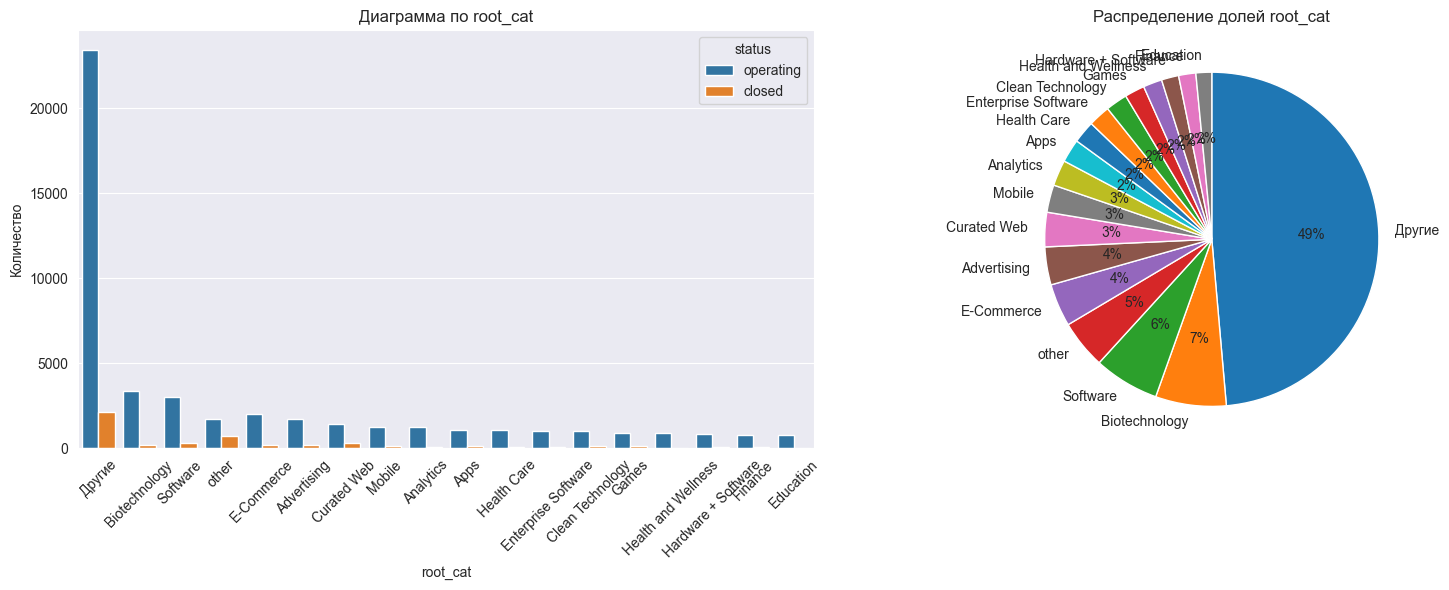

In [44]:
# Визуализируем признаки
all_diag(train, column_type='categorical', hue='status')

При построении графиков значения категориальных признаков занимающие менее 1,5% были собюраны в категорию 'Другие' для лучшей визуализации

- name - все значения уникальны, что ожидаемо
- status - целевой признак, по графику мы видим сильный дисбаланс классов, только 9% из всех стартапов закрылись.
- country_code - основная страна регистрации стартапов - США с долей 63%, затем идут Великобритания и Канада с 6 и 3%.
- state_code - самый распространенный штат регистрации стартапов - Калифорния, за ним идут Нью-Йорк и Массачусетс
- region - самый популярные регион это Область Залива Сан-Франциско и Нью-Йорк с 15% и 6% соответственно
- city - Сан Франциско у нас город стартапов с 63% и Лондон на втором месте всего с 6%
- end-cat - В топе у нас программное обеспечение и биотехнологии
- root-cat - тут также лидирует програмное обеспечение и биотехнологии

- Распределение целевой переменной совпадает с распеределением всех признаков.

### 2.3. Анализ признаков с датами

In [45]:
# Создадим функцию для визуализации признаков дат
def date_diag(data, date_col, hue=None,
                          figsize=(12, 6)):

    df = data.copy()
    df['year'] = df[date_col].dt.year

    plt.figure(figsize=figsize)
    ax = sns.countplot(
        data=df,
        x='year',
        hue=hue,
        order=sorted(df['year'].unique())
    )

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', padding=3)

    plt.title(f'Распределение данных по годам\n({date_col})')
    plt.xlabel('Год')
    plt.ylabel('Количество записей')
    plt.xticks(rotation=45)

    if hue:
        plt.legend(
            title=hue,
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0
        )

    plt.tight_layout()
    plt.show()

Визуализация категориального признака: first_funding_at


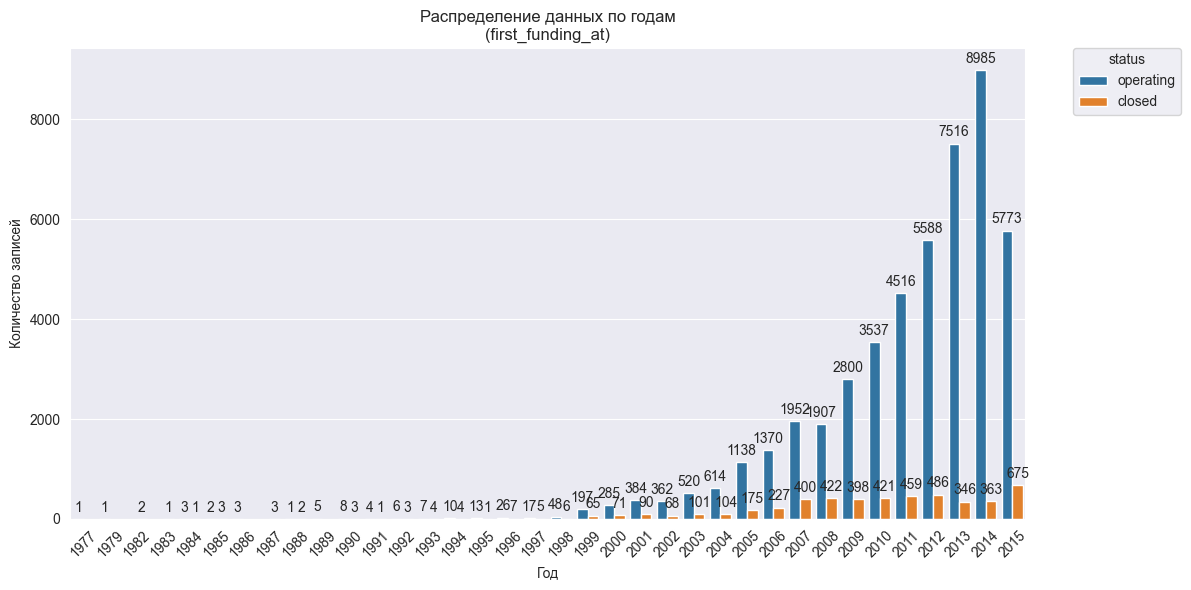

Визуализация категориального признака: last_funding_at


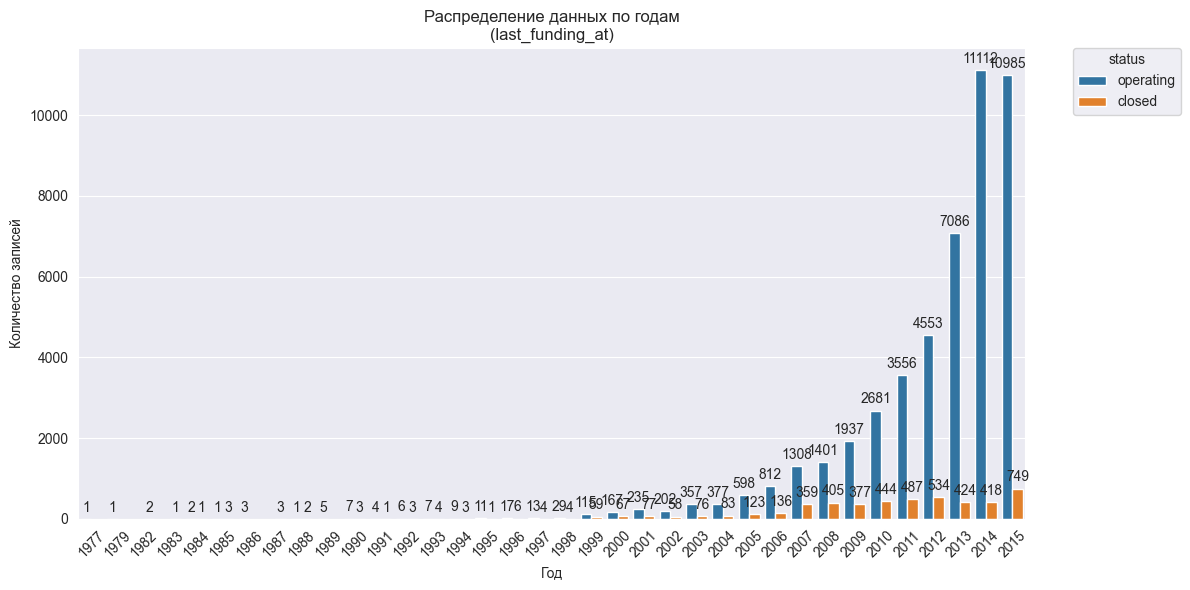

In [46]:
# Визуализируем даты
for date_col in date_cols2:
    print(f"Визуализация категориального признака: {date_col}")
    date_diag(train, date_col, hue='status')

- founded_at - большинство стартапов было основано с 2005 по 2014 год, также в эти периоды приходится основная часть закрытия стартапов. Количество закрытий напрямую с количеством открыти не коррелирует. Максимальное количетво закрытых стартапов было в 2011 году а максимальное количество открытых в 2013.
- first_funding_at - распределение дат первого раунда финансирования совпадают с распределеним с созданием стартапов. Максимальное количество стартапов прошедших первых раундов финансирования было в 2014 году.
- last_funding_at - распределение дат последнего раунда финансирования также похожи на график основания стартапов. Максимальное количество дат посоледнего финансирования было в 2014 и 2015 годах
- closed_at - основное количество закрытия стартапов проходилось с 2008 по 2017 год
- основная активность финансирования, закрытия и открытия стартапов начинается с 90x-2000x годов, до этого активность минамальна



In [47]:
# Заполним пропуски в столбце closed_at текущей датой
train['closed_at'] = train['closed_at'].fillna(pd.to_datetime(datetime.now().date()))

In [48]:
# Создадим стобец lifetime как разницу между датой основания стартапа и разницей закрытия в днях
train['lifetime'] = (train['closed_at'] - train['founded_at']).dt.days

In [49]:
date_cols = ['first_funding_at', 'last_funding_at']

In [50]:
# Добавим в датасеты колонки с годами месяцами и днями по первому и последнему финансированию
for col in date_cols:
    train[f'{col}_year'] = train[col].dt.year
    train[f'{col}_month'] = train[col].dt.month
    train[f'{col}_day'] = train[col].dt.day
    test[f'{col}_year'] = train[col].dt.year
    test[f'{col}_month'] = train[col].dt.month
    test[f'{col}_day'] = train[col].dt.day

In [51]:
# Список столбцов для удаления
columns_to_drop = ['founded_at', 'closed_at']
train = train.drop(columns=columns_to_drop)

In [52]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,end_cat,root_cat,lifetime,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
0,Lunchgate,Online Reservations|Restaurants,828626.00,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,Restaurants,Online Reservations,5643,2011,5,1,2014,12,1
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.00,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,Medical Devices,Manufacturing,7393,2010,5,4,2014,2,25
2,Reviva Pharmaceuticals,Biotechnology,35456381.00,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,Biotechnology,Biotechnology,7028,2012,8,20,2014,7,2
3,Sancilio and Company,Health Care,22250000.00,operating,NaN,NaN,NaN,NaN,3,2011-09-01,2014-07-18,Health Care,Health Care,7759,2011,9,1,2014,7,18
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2012-02-01,2012-02-01,Manufacturing,Manufacturing,5436,2012,2,1,2012,2,1


In [53]:
# Сформируем список новых колонок для анализа
date_num = ['lifetime',
            'first_funding_at_year',
            'first_funding_at_month',
            'first_funding_at_day',
            'last_funding_at_year',
            'last_funding_at_month',
            'last_funding_at_day']

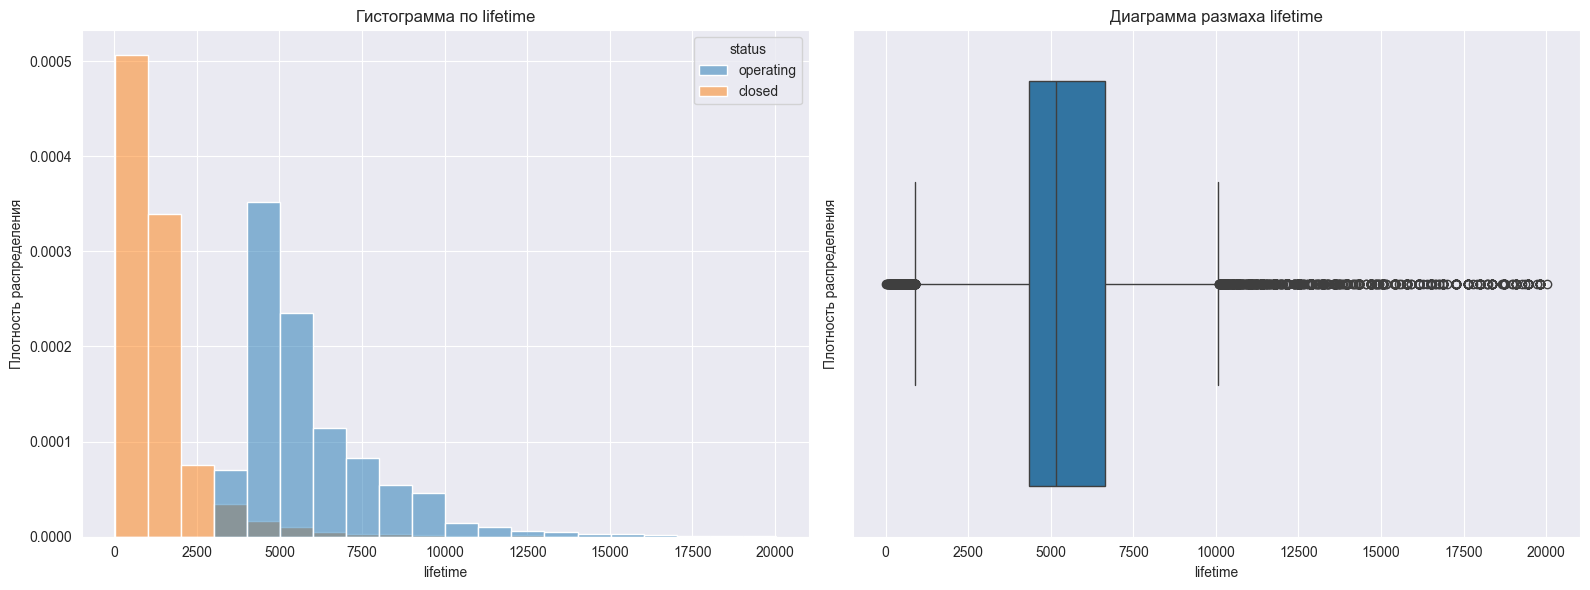

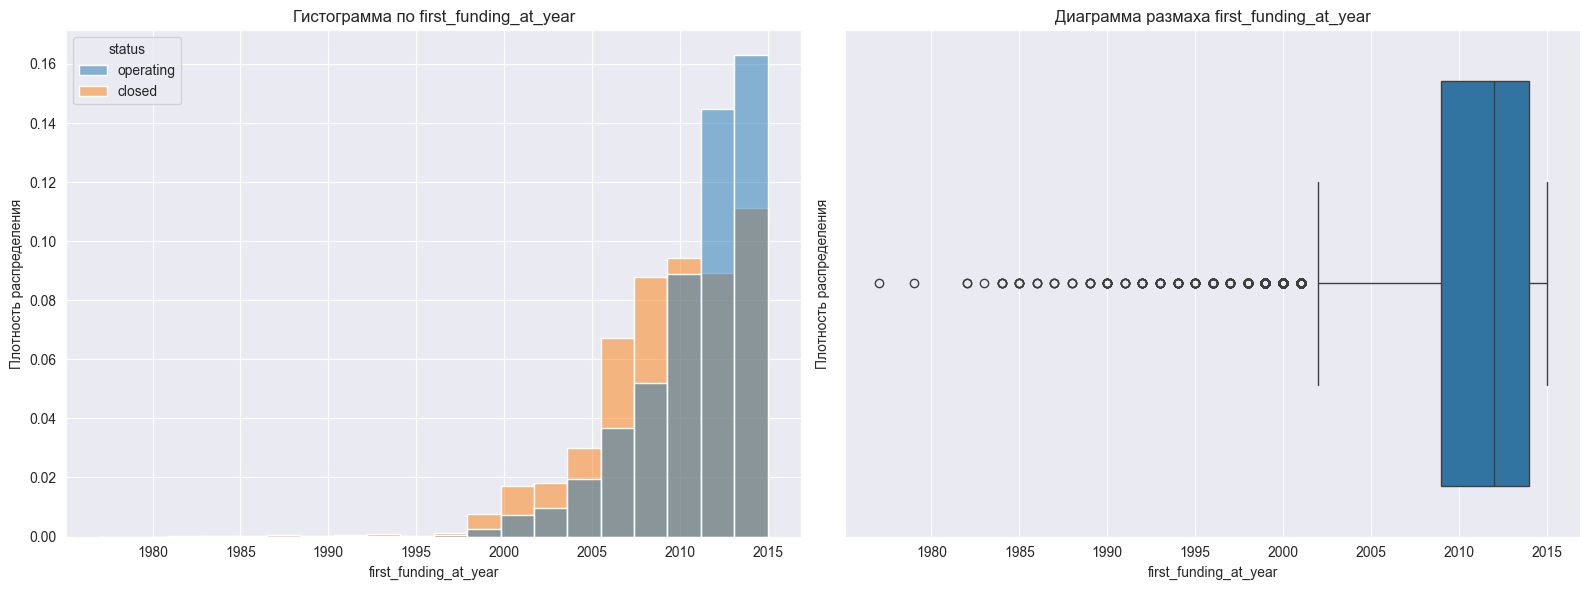

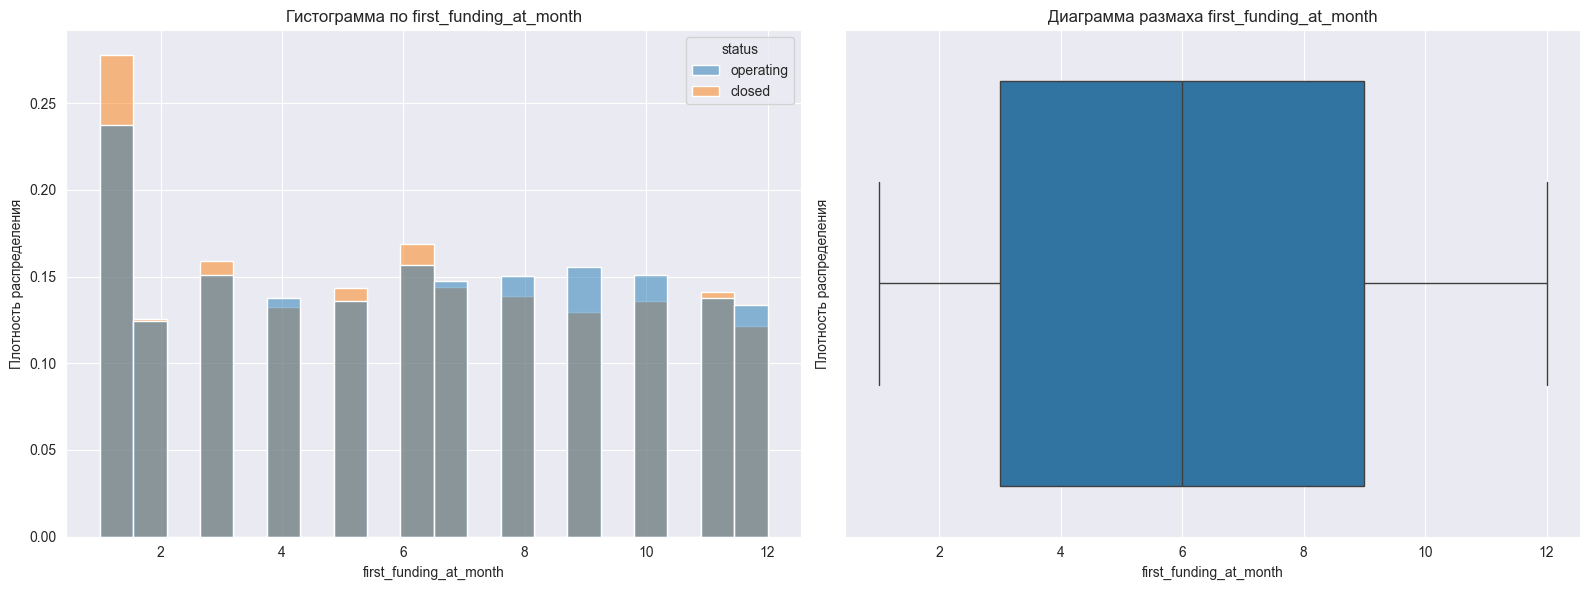

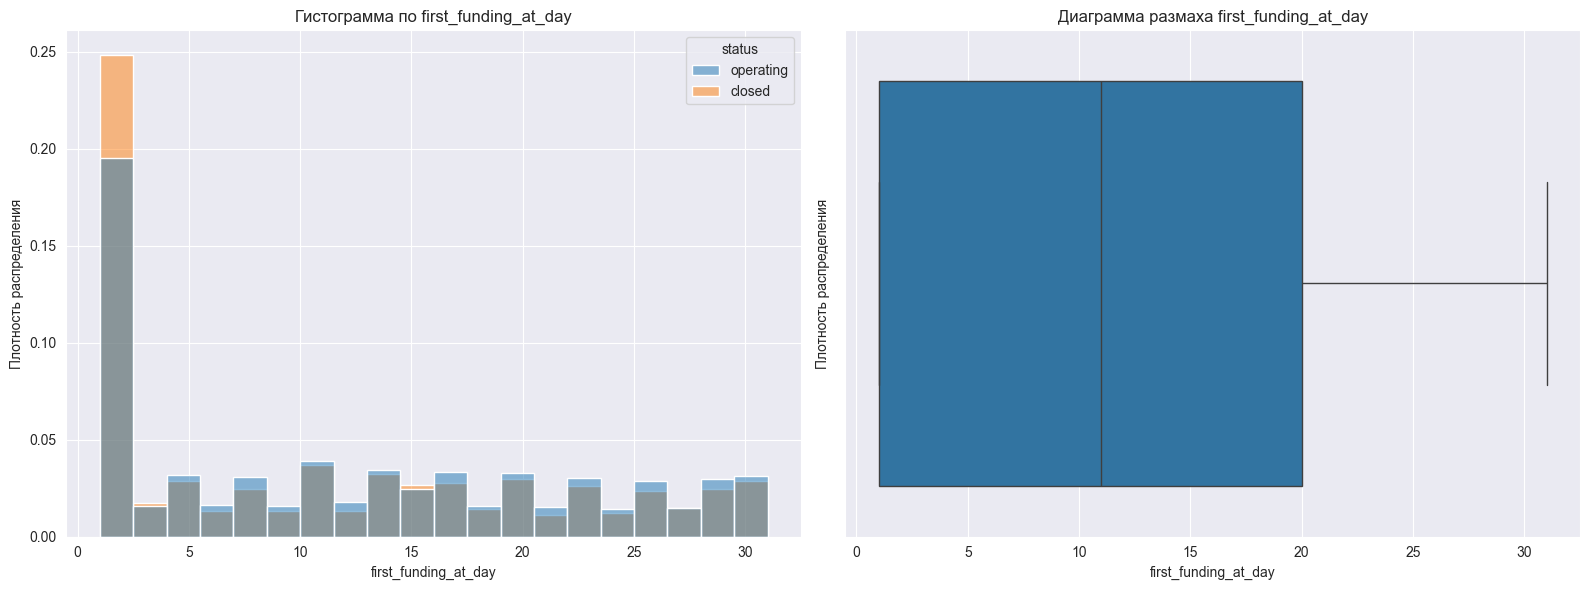

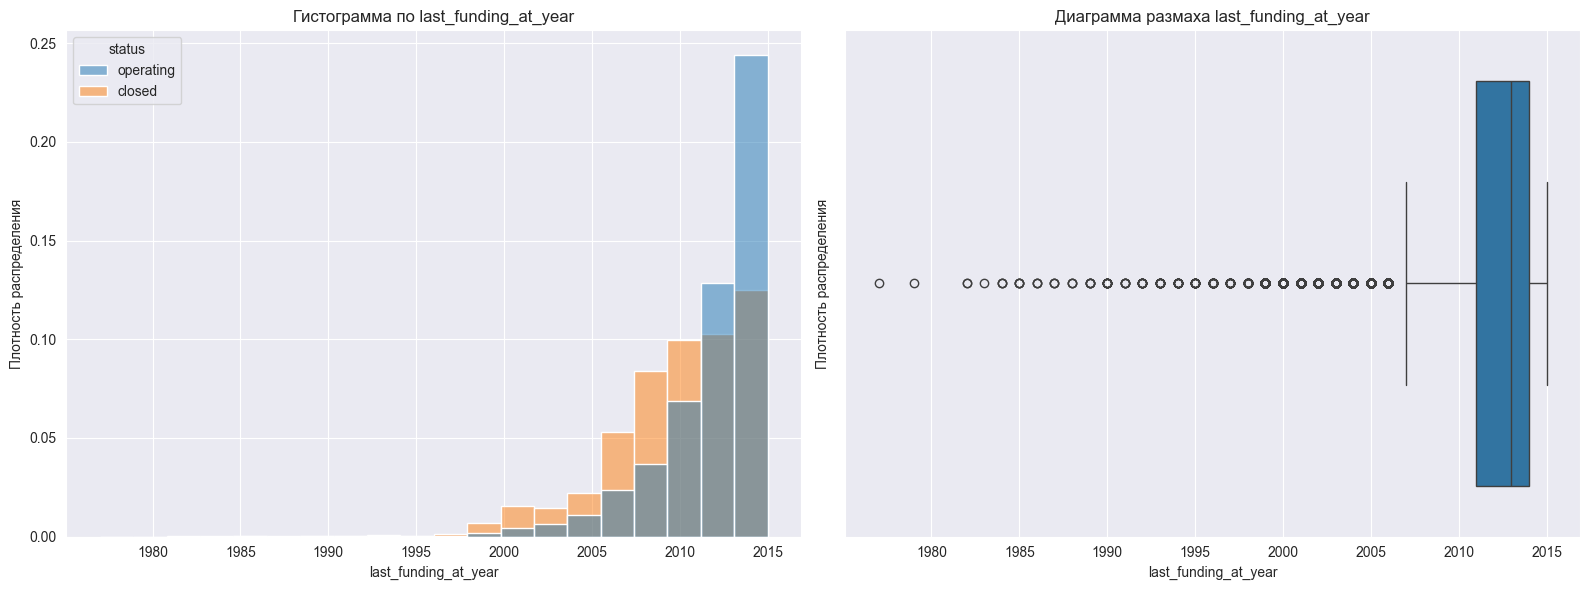

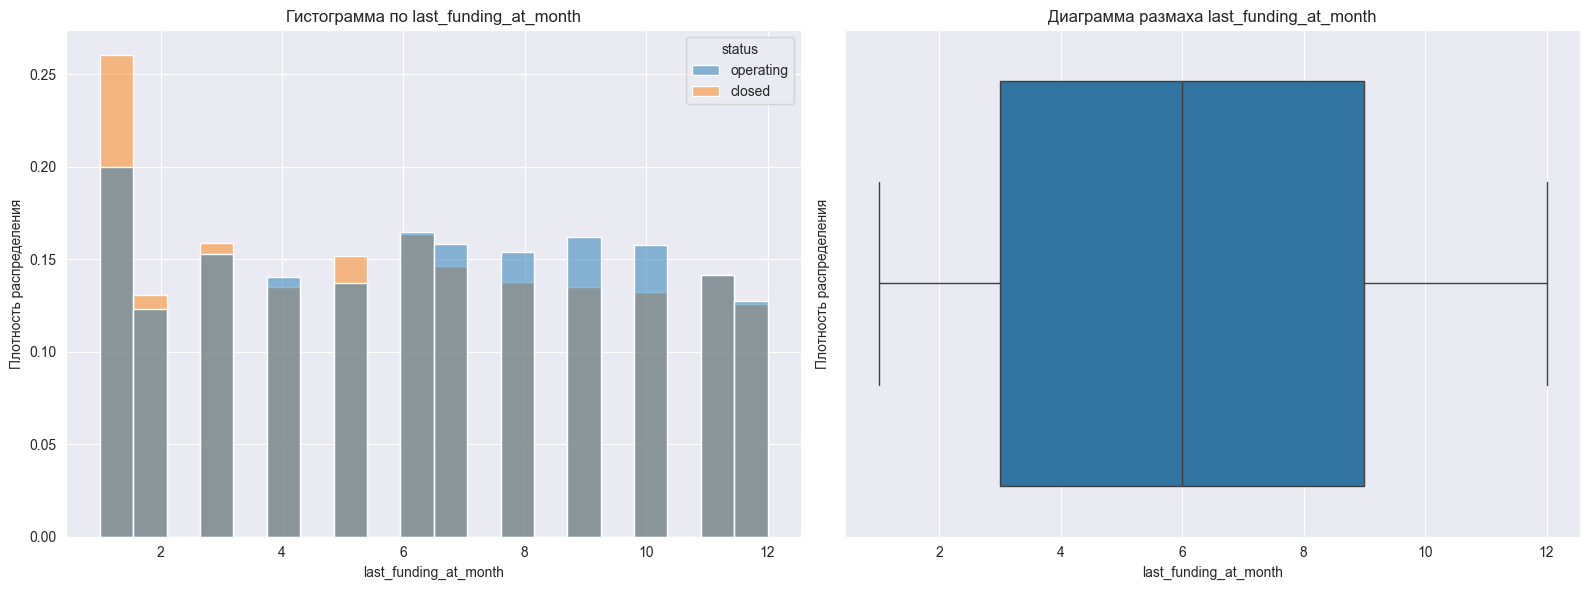

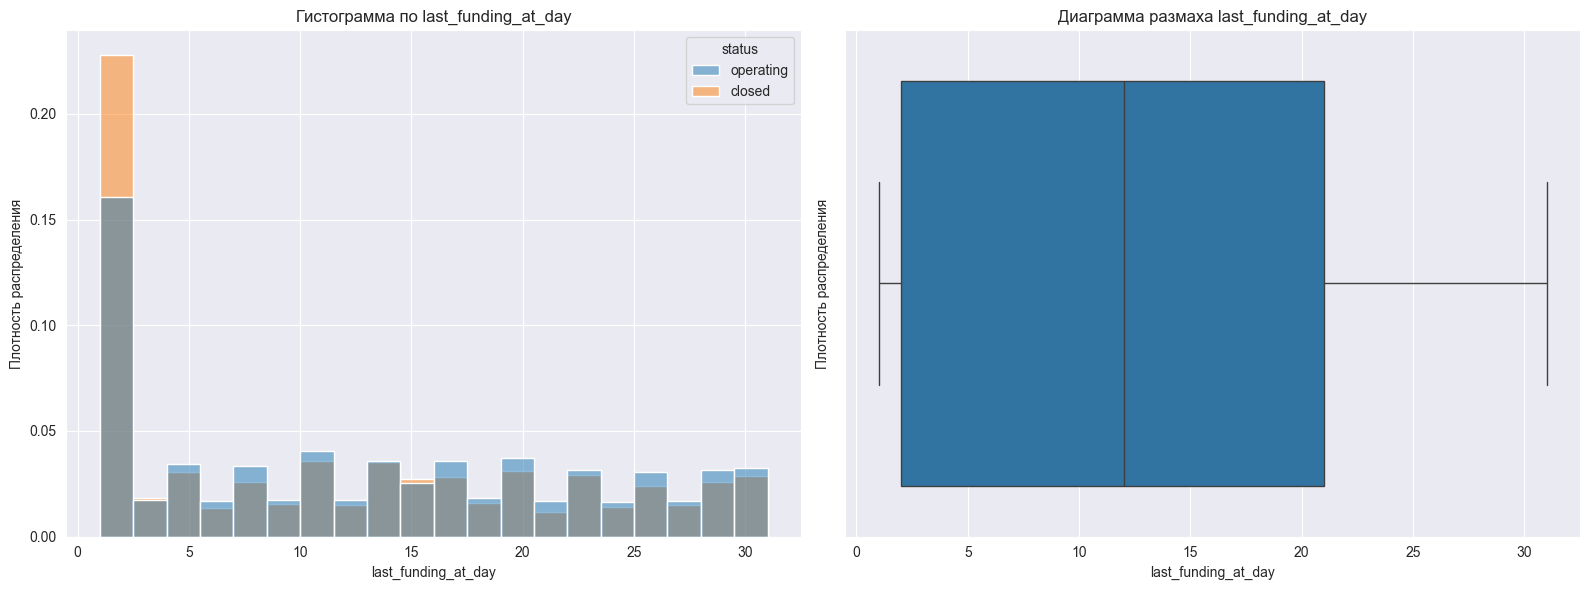

In [54]:
# Построим графики новых колонок
for col in date_num:
    num_diag(train, x=col, xlabel=col, ylabel='Плотность распределения', hue='status')

In [55]:
train['lifetime'].describe()

count   52516.00
mean     5538.18
std      2463.63
min        19.00
25%      4332.00
50%      5159.00
75%      6631.00
max     20023.00
Name: lifetime, dtype: float64

- lifetime - стартапы закрываются в первые 1,5-2 тыс. дней, основная часть работающих стартапов просуществовало уже 4-6 тыс дней.

In [56]:
train['first_funding_at_year'].describe()

count   52516.00
mean     2011.08
std         3.61
min      1977.00
25%      2009.00
50%      2012.00
75%      2014.00
max      2015.00
Name: first_funding_at_year, dtype: float64

- first_funding_at_year - основная масса финансирований стартапов началась в 2005 году и все время росла. Интересно что в более ранние периоды закрывалась большая доля стартапов чем в последующие. Видимо научились правильно выбирать стартапы для финансирования.

In [57]:
train['first_funding_at_month'].describe()

count   52516.00
mean        6.23
std         3.53
min         1.00
25%         3.00
50%         6.00
75%         9.00
max        12.00
Name: first_funding_at_month, dtype: float64

- first_funding_at_month - первое финансирование стартапов чаще всего происходило в середине года.

In [58]:
train['first_funding_at_day'].describe()

count   52516.00
mean       11.95
std         9.88
min         1.00
25%         1.00
50%        11.00
75%        20.00
max        31.00
Name: first_funding_at_day, dtype: float64

- first_funding_at_day - первое финансирование стартапов чаще всего происходило в начале месяца.

In [59]:
train['last_funding_at_year'].describe()

count   52516.00
mean     2012.01
std         3.34
min      1977.00
25%      2011.00
50%      2013.00
75%      2014.00
max      2015.00
Name: last_funding_at_year, dtype: float64

- last_funding_at_year - распределение похоже на первое финансирование, только сдвинуто на год вперед, что логично.

In [60]:
train['last_funding_at_month'].describe()

count   52516.00
mean        6.35
std         3.46
min         1.00
25%         3.00
50%         6.00
75%         9.00
max        12.00
Name: last_funding_at_month, dtype: float64

- last_funding_at_month - последнее финансирование стартапов также чаще всего происходило в середине года.

In [61]:
train['last_funding_at_day'].describe()

count   52516.00
mean       12.76
std         9.77
min         1.00
25%         2.00
50%        12.00
75%        21.00
max        31.00
Name: last_funding_at_day, dtype: float64

- last_funding_at_day - последнее финансирование стартапов чаще всего происходило в начале месяца.

### Вывод

## 3. Корреляционный анализ

### 3.1. Матрица корреляций

In [63]:
train_b = train.select_dtypes(include='number')
display(train_b.corr('spearman'))

,funding_total_usd,funding_rounds,lifetime,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
funding_total_usd,1.00,0.45,0.43,-0.39,0.01,0.10,-0.07,0.03,0.17
funding_rounds,0.45,1.00,0.20,-0.29,-0.02,-0.06,0.19,0.03,0.07
lifetime,0.43,0.20,1.00,-0.56,-0.01,0.05,-0.40,-0.01,0.07
first_funding_at_year,-0.39,-0.29,-0.56,1.00,-0.02,0.07,0.80,-0.00,0.02
first_funding_at_month,0.01,-0.02,-0.01,-0.02,1.00,0.10,-0.01,0.65,0.07
first_funding_at_day,0.10,-0.06,0.05,0.07,0.10,1.00,0.05,0.06,0.69
last_funding_at_year,-0.07,0.19,-0.40,0.80,-0.01,0.05,1.00,-0.03,0.08
last_funding_at_month,0.03,0.03,-0.01,-0.00,0.65,0.06,-0.03,1.00,0.06
last_funding_at_day,0.17,0.07,0.07,0.02,0.07,0.69,0.08,0.06,1.00


In [64]:
# Cоздадим матрицу корреaляции phik
phk = train_b.phik_matrix(verbose=False)

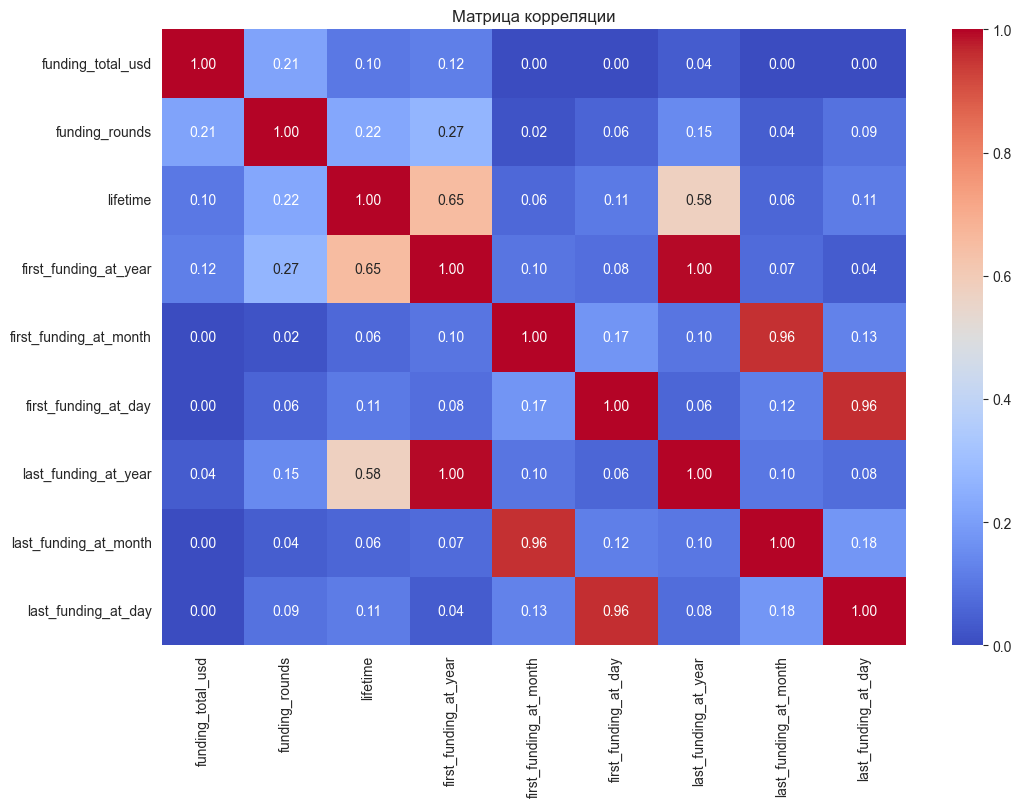

In [65]:
# Визуализируем матрицу корреляции
plt.figure(figsize=(12, 8))
plt.title('Матрица корреляции')
sns.heatmap(phk, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Анализ матрицы корреляции:

Общие наблюдения:

Диагональ матрицы заполнена единицами, так как каждая переменная полностью коррелирует сама с собой.

Цветовая гамма указывает на силу корреляции: красные и коричневые оттенки — высокая корреляция, темно-синие — низкая.

Ключевые корреляции:

- funding_total_usd и funding_rounds (0.32): Средняя положительная корреляция, что логично — больше раундов финансирования связано с большей суммой полученных средств.

- lifetime и first_funding_at_year (0.68): Достаточно высокая корреляция, что логично, поскольку компании, начавшие финансирование раньше, вероятно, существуют дольше.
-

- last_funding_at_year и lifetime (0.59): Средне-высокая положительная корреляция, что ожидаемо — чем дольше компания на рынке, тем позже она могла получить финансирование.

Слабые корреляции:

- funding_total_usd с большинством других переменных (≤ 0.32): Общая сумма привлеченных средств слабо связана с конкретными датами финансирования.

- first_funding_at_month и другие временные переменные (≤ 0.25): Месяц первого финансирования практически не влияет на другие параметры.-

Высокая корреляция между датами:

- first_funding_at_day и last_funding_at_day (0.99): Почти полная корреляция.

- first_funding_at_month и last_funding_at_month (0.96): Также очень высокая корреляция.

Вывод:
Матрица корреляции показывает, что ключевые финансовые параметры (сумма финансирования и количество раундов) не сильно коррелируют с датами, но есть очевидные закономерности между временем существования компании и ее финансированием. Высокие корреляции между датами могут указывать на особенности сбора данных или ошибки.

### 3.2 Мультиколлинеарность

In [66]:
# Добавим константу
df_with_const = add_constant(train_b)

In [67]:
# Определим функцию подсчета VIF
def calc_vif(df):

    vif_data = pd.DataFrame()
    vif_data["variables"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return vif_data

In [68]:
# Рассчитаем VIF
train_b = train_b.dropna()
calc_vif(train_b)

,variables,VIF
0,funding_total_usd,1.03
1,funding_rounds,2.41
2,lifetime,1.09
3,first_funding_at_year,7.94
4,first_funding_at_month,1.56
5,first_funding_at_day,1.65
6,last_funding_at_year,6.60
7,last_funding_at_month,1.56
8,last_funding_at_day,1.64


`Ключевые пороги для VIF:
- VIF < 5: Минимальная мультиколлинеарность, это нормально.
- 5 ≤ VIF ≤ 10: Признак умеренной мультиколлинеарности, стоит обратить внимание.
- VIF > 10: Сильная мультиколлинеарность, вероятно, данные коррелируют с другими, стоит рассмотреть их исключение или трансформацию.

Разбор значений:
- funding_total_usd (1.03) → Очень низкий VIF, нет мультиколлинеарности.
- funding_rounds (2.41) → Умеренный уровень, но в пределах нормы.
- lifetime (1.09) → Очень низкий, нет мультиколлинеарности.
- first_funding_at_year (7.94) → Высокий уровень! Может быть сильная корреляция с last_funding_at_year.
- first_funding_at_month (1.56) → Низкий, нет проблем.
- first_funding_at_day (1.65) → Низкий, нет проблем.
- last_funding_at_year (6.60) → Высокий уровень! Вероятно, сильно связан с first_funding_at_year.
- last_funding_at_month (1.56) → Низкий, нет проблем.
- last_funding_at_day (1.64) → Низкий, нет проблем.

### Вывод

## 4. Моделирование

In [69]:
# Удаляем лишние колонки
train = train.drop(columns=['category_list',
                            'first_funding_at',
                            'last_funding_at',
                            'last_funding_at_year',
                            'last_funding_at_month',
                            'last_funding_at_day'])

In [70]:
train.head()

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,end_cat,root_cat,lifetime,first_funding_at_year,first_funding_at_month,first_funding_at_day
0,Lunchgate,828626.00,operating,CHE,25,Zurich,Zürich,2,Restaurants,Online Reservations,5643,2011,5,1
1,EarLens,42935019.00,operating,USA,CA,SF Bay Area,Redwood City,4,Medical Devices,Manufacturing,7393,2010,5,4
2,Reviva Pharmaceuticals,35456381.00,operating,USA,CA,SF Bay Area,San Jose,3,Biotechnology,Biotechnology,7028,2012,8,20
3,Sancilio and Company,22250000.00,operating,NaN,NaN,NaN,NaN,3,Health Care,Health Care,7759,2011,9,1
4,WireTough Cylinders,NaN,operating,USA,VA,VA - Other,Bristol,1,Manufacturing,Manufacturing,5436,2012,2,1


In [71]:
# Отделим целевой признак от обучающей выборки
X = train.drop(columns=['status']).set_index('name')
y = train['status']

In [72]:
# Разделим датасет на тренировочные и валидационные данные
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = y
)

In [131]:
numeric_features = ['funding_rounds', 'funding_total_usd', 'lifetime', 'first_funding_at_year', 'first_funding_at_month', 'first_funding_at_day']
categorical_features = ['country_code', 'state_code', 'region', 'city', 'end_cat', 'root_cat']

In [132]:
class FeatureNamer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if hasattr(X, 'columns'):
            return X
        return pd.DataFrame(X, columns=self.feature_names)

In [133]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_namer', FeatureNamer(feature_names=preprocessor.get_feature_names_out())),
    ('classifier', LGBMClassifier())
])

X_train.columns = X_train.columns.astype(str)

param_grid = [
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': range(1, 20),
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'classifier': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'classifier__max_depth': range(2, 11),
        'classifier__min_samples_split': range(2, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'classifier': [SVC(random_state=RANDOM_STATE, probability=True)],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__C': range(1, 10, 1),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'classifier': [LogisticRegression(random_state=RANDOM_STATE)],
        'classifier__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'classifier': [LGBMClassifier(random_state=RANDOM_STATE)],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.5],
        'classifier__max_depth': [3, 5, 7],
        'preprocessor__num__scaler': ['passthrough']
    }
]

f1_scorer = make_scorer(f1_score, pos_label='operating')

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2,
    refit=True
)

random_search.fit(X_train, y_train)

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [125]:
def predict_with_features(model, X):
    X_processed = pd.DataFrame(
        preprocessor.transform(X),
        columns=feature_names,
        index=X.index
    )
    return model.predict(X_processed)

In [126]:
y_pred = predict_with_features(random_search.best_estimator_, X_test)
print(classification_report(y_test, y_pred))

ValueError: columns are missing: {'funding_rounds', 'city', 'first_funding_at_year', 'lifetime', 'first_funding_at_month', 'funding_total_usd', 'state_code', 'first_funding_at_day', 'end_cat', 'root_cat', 'region', 'country_code'}